<a href="https://colab.research.google.com/github/muhammmad-al/decentralized-ai-content-recommender/blob/main/reddit_federated_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/content
Cloning into 'decentralized-ai-content-recommender'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 124 (delta 43), reused 57 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (124/124), 11.73 MiB | 17.36 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/decentralized-ai-content-recommender
Starting Federated Learning Training...

Node 1 (NA) Dataset Overview:
Total samples: 6694

Interaction Statistics:
Posts with interactions: 2115
Interaction rate: 31.60%
Average engagement duration: 0.00

Node 2 (EU) Dataset Overview:
Total samples: 4481

Interaction Statistics:
Posts with interactions: 1595
Interaction rate: 35.59%
Average engagement duration: 0.00

Node 3 (ASIA) Dataset Overview:
Total samples: 3825

Interaction Statistics:
Posts with interactions: 1288
Interaction rate: 33.67%
Average engagement duration: 0.00

Federated Round 1/5

Training Node 

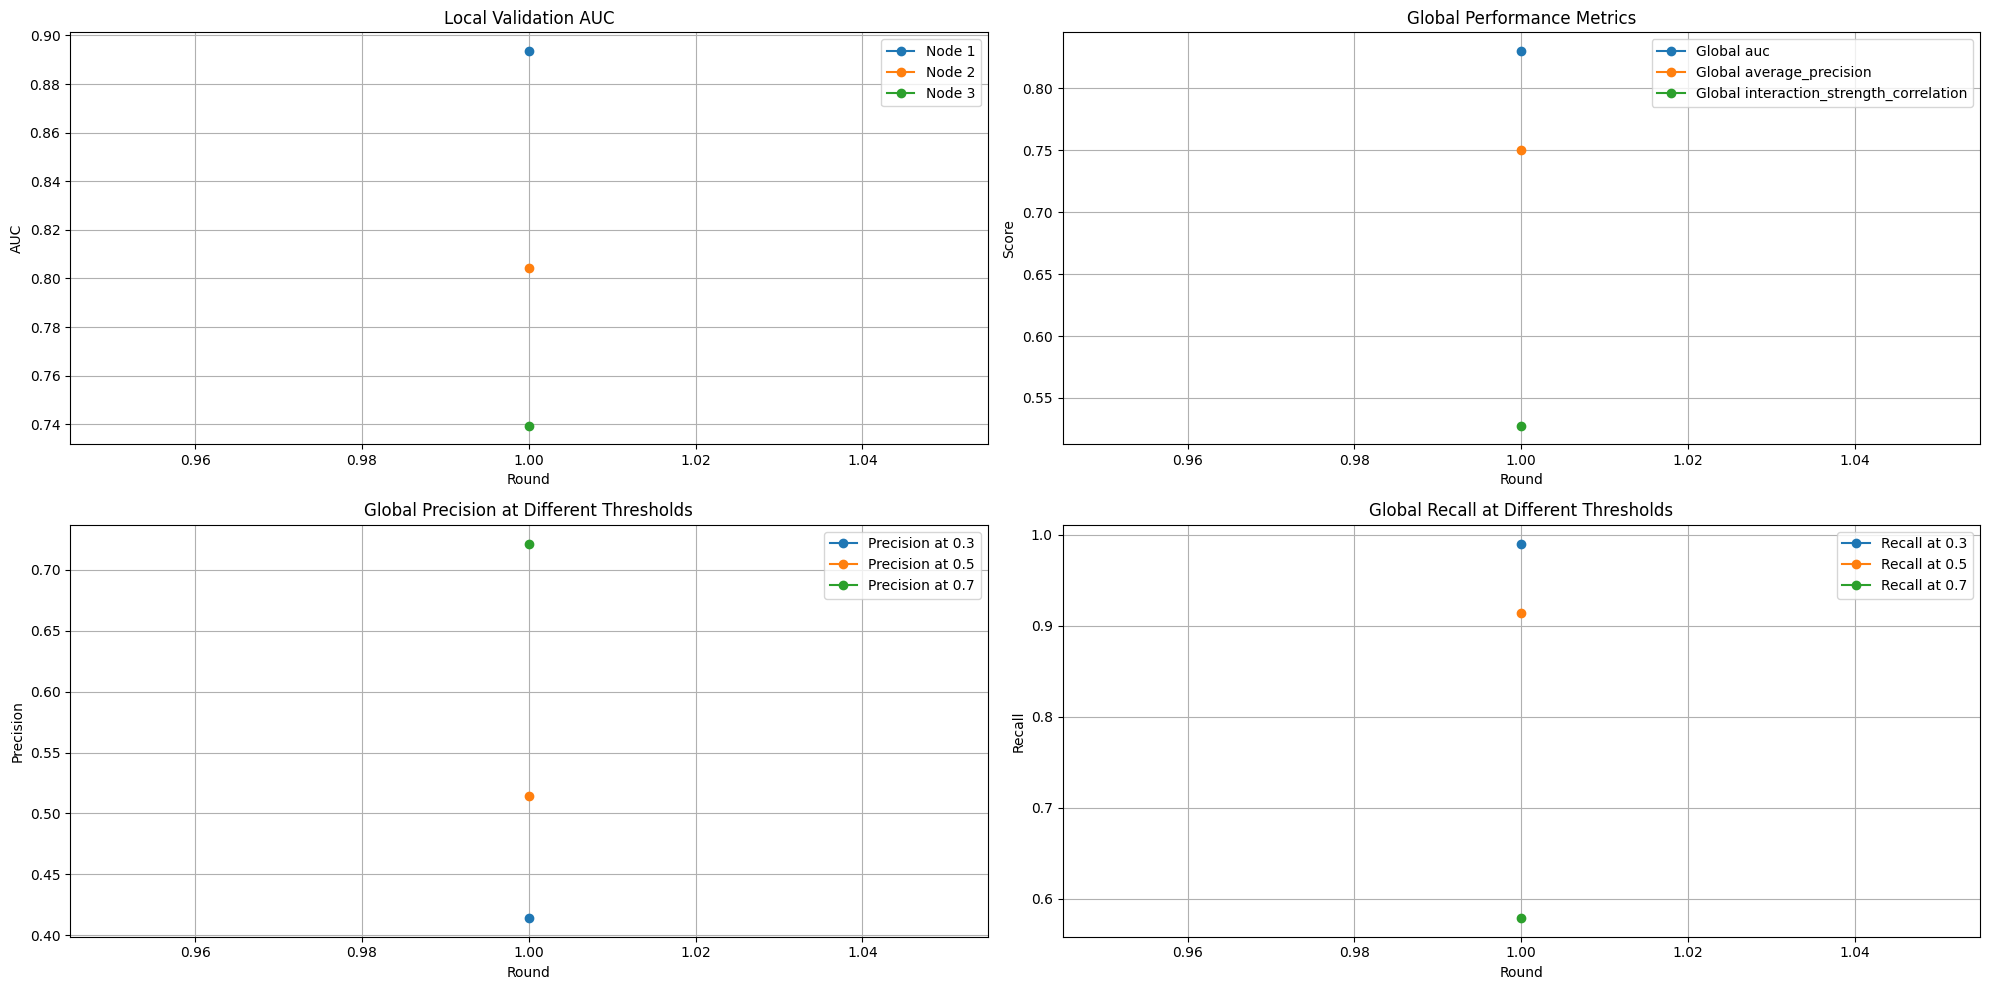


Federated Round 2/5

Training Node 1
Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6684 - auc: 0.8786 - loss: 0.5032 - precision: 0.4679 - recall: 0.9597 - val_accuracy: 0.7627 - val_auc: 0.9353 - val_loss: 0.4282 - val_precision: 0.5556 - val_recall: 0.9585
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7217 - auc: 0.9246 - loss: 0.4348 - precision: 0.5085 - recall: 0.9762 - val_accuracy: 0.7833 - val_auc: 0.9461 - val_loss: 0.3884 - val_precision: 0.5798 - val_recall: 0.9521
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7558 - auc: 0.9467 - loss: 0.3749 - precision: 0.5527 - recall: 0.9771 - val_accuracy: 0.8124 - val_auc: 0.9480 - val_loss: 0.3788 - val_precision: 0.6175 - val_recall: 0.9489
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7847 - auc: 0.9551 - loss: 0.3573 - precision: 0.5731 - recall: 0.9778 - val_accuracy: 0.8011 - val_auc: 0.9478 - val_loss: 0.3747 - val_precision: 0.6046 - val_recall: 0.93

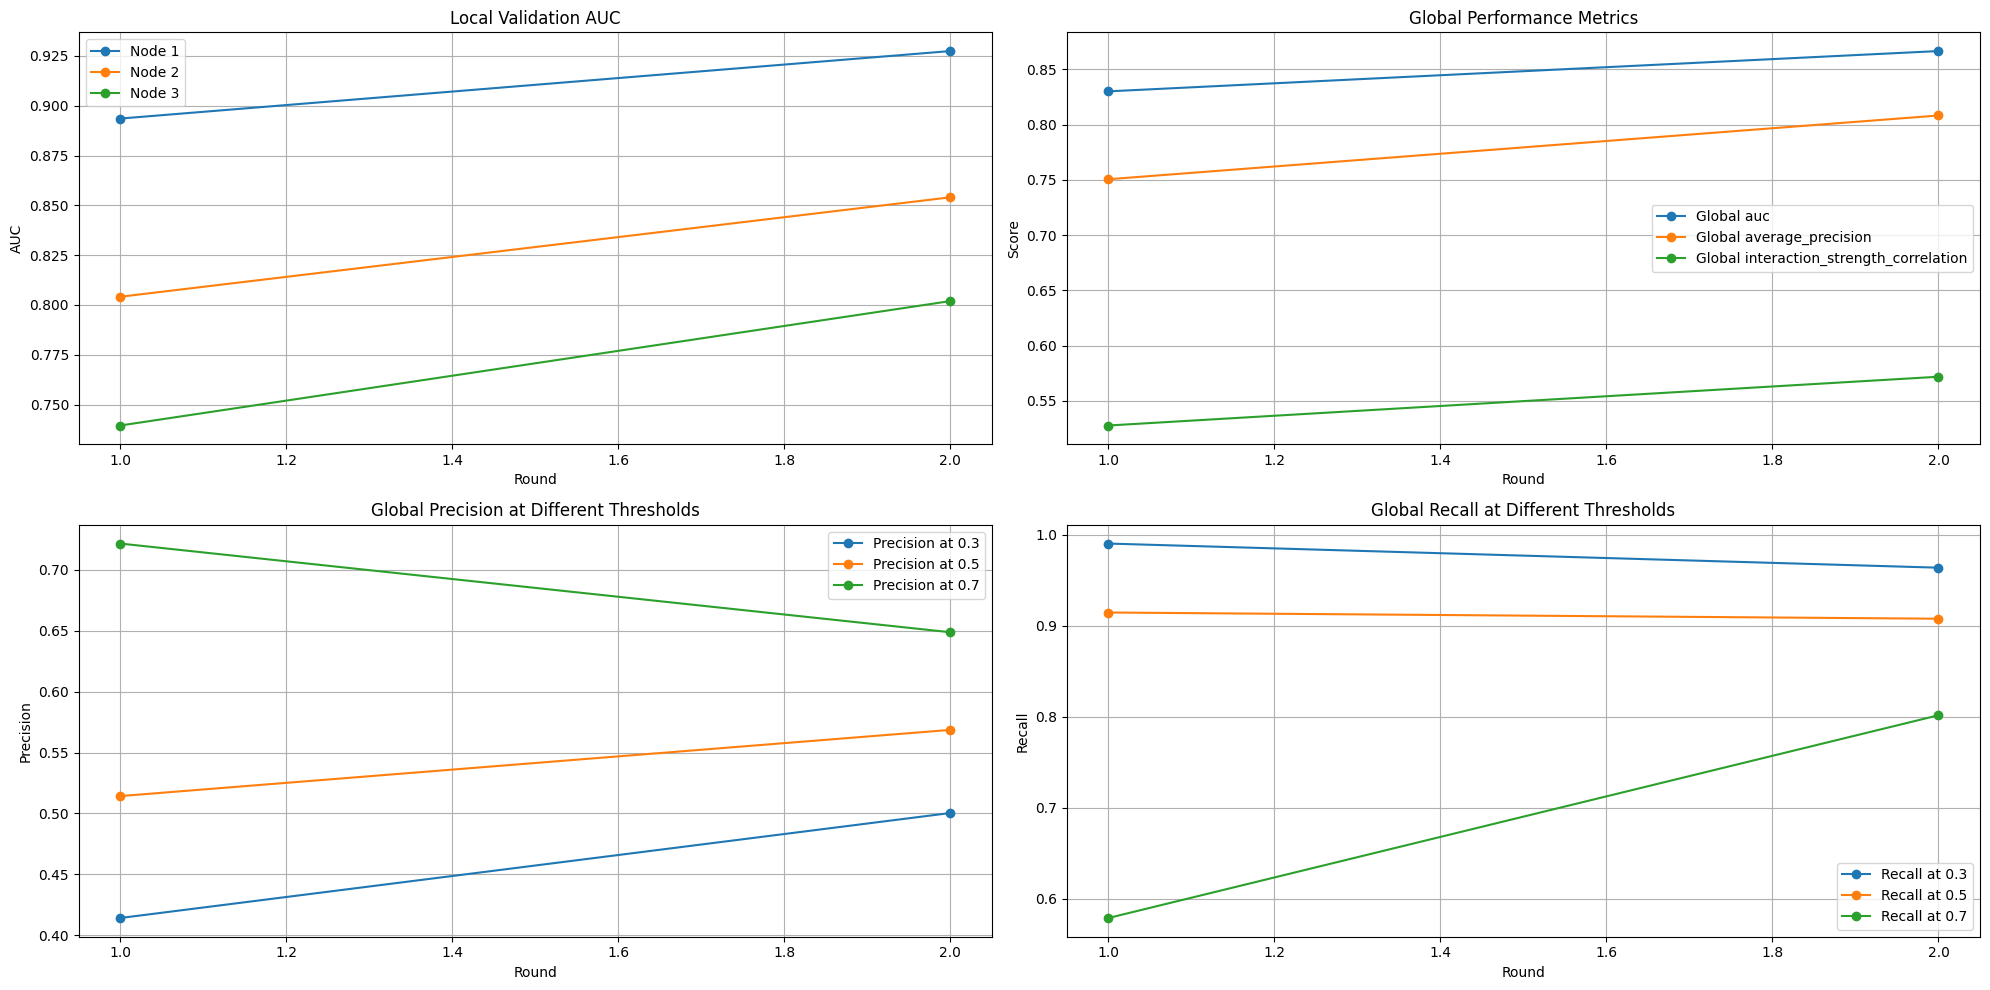


Federated Round 3/5

Training Node 1
Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7294 - auc: 0.9137 - loss: 0.4098 - precision: 0.5263 - recall: 0.9568 - val_accuracy: 0.8124 - val_auc: 0.9453 - val_loss: 0.3771 - val_precision: 0.6175 - val_recall: 0.9489
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7530 - auc: 0.9411 - loss: 0.3509 - precision: 0.5347 - recall: 0.9743 - val_accuracy: 0.8161 - val_auc: 0.9522 - val_loss: 0.3474 - val_precision: 0.6216 - val_recall: 0.9553
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7934 - auc: 0.9541 - loss: 0.3289 - precision: 0.5933 - recall: 0.9825 - val_accuracy: 0.8161 - val_auc: 0.9499 - val_loss: 0.3294 - val_precision: 0.6221 - val_recall: 0.9521
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8041 - auc: 0.9623 - loss: 0.3075 - precision: 0.5986 - recall: 0.9781 - val_accuracy: 0.8199 - val_auc: 0.9514 - val_loss: 0.3430 - val_precision: 0.6296 - val_recall: 0.939

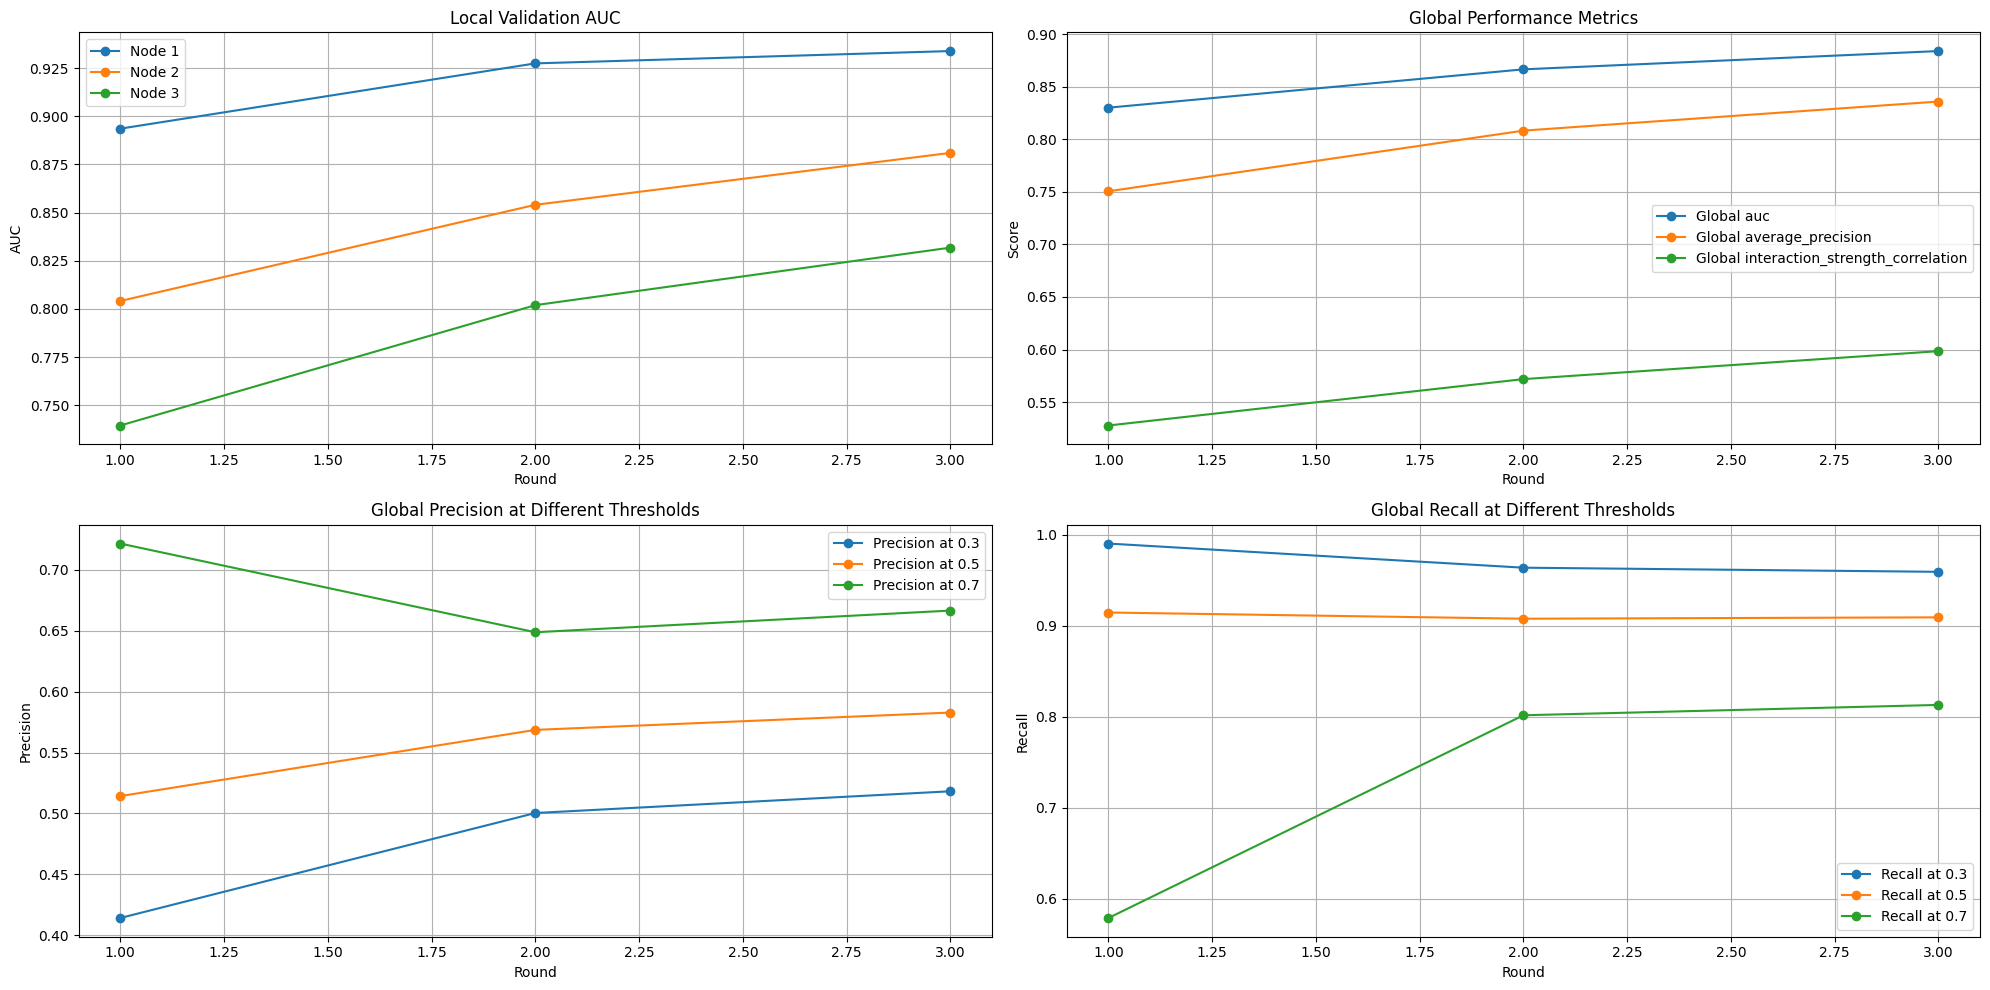


Federated Round 4/5

Training Node 1
Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7321 - auc: 0.9218 - loss: 0.3812 - precision: 0.5289 - recall: 0.9509 - val_accuracy: 0.7964 - val_auc: 0.9487 - val_loss: 0.3293 - val_precision: 0.5952 - val_recall: 0.9585
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7669 - auc: 0.9485 - loss: 0.3209 - precision: 0.5523 - recall: 0.9803 - val_accuracy: 0.8077 - val_auc: 0.9462 - val_loss: 0.3310 - val_precision: 0.6102 - val_recall: 0.9553
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7987 - auc: 0.9539 - loss: 0.3127 - precision: 0.5986 - recall: 0.9750 - val_accuracy: 0.8086 - val_auc: 0.9525 - val_loss: 0.3241 - val_precision: 0.6119 - val_recall: 0.9521
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8149 - auc: 0.9656 - loss: 0.2717 - precision: 0.6126 - recall: 0.9851 - val_accuracy: 0.7946 - val_auc: 0.9441 - val_loss: 0.3148 - val_precision: 0.5933 - val_recall: 0.95

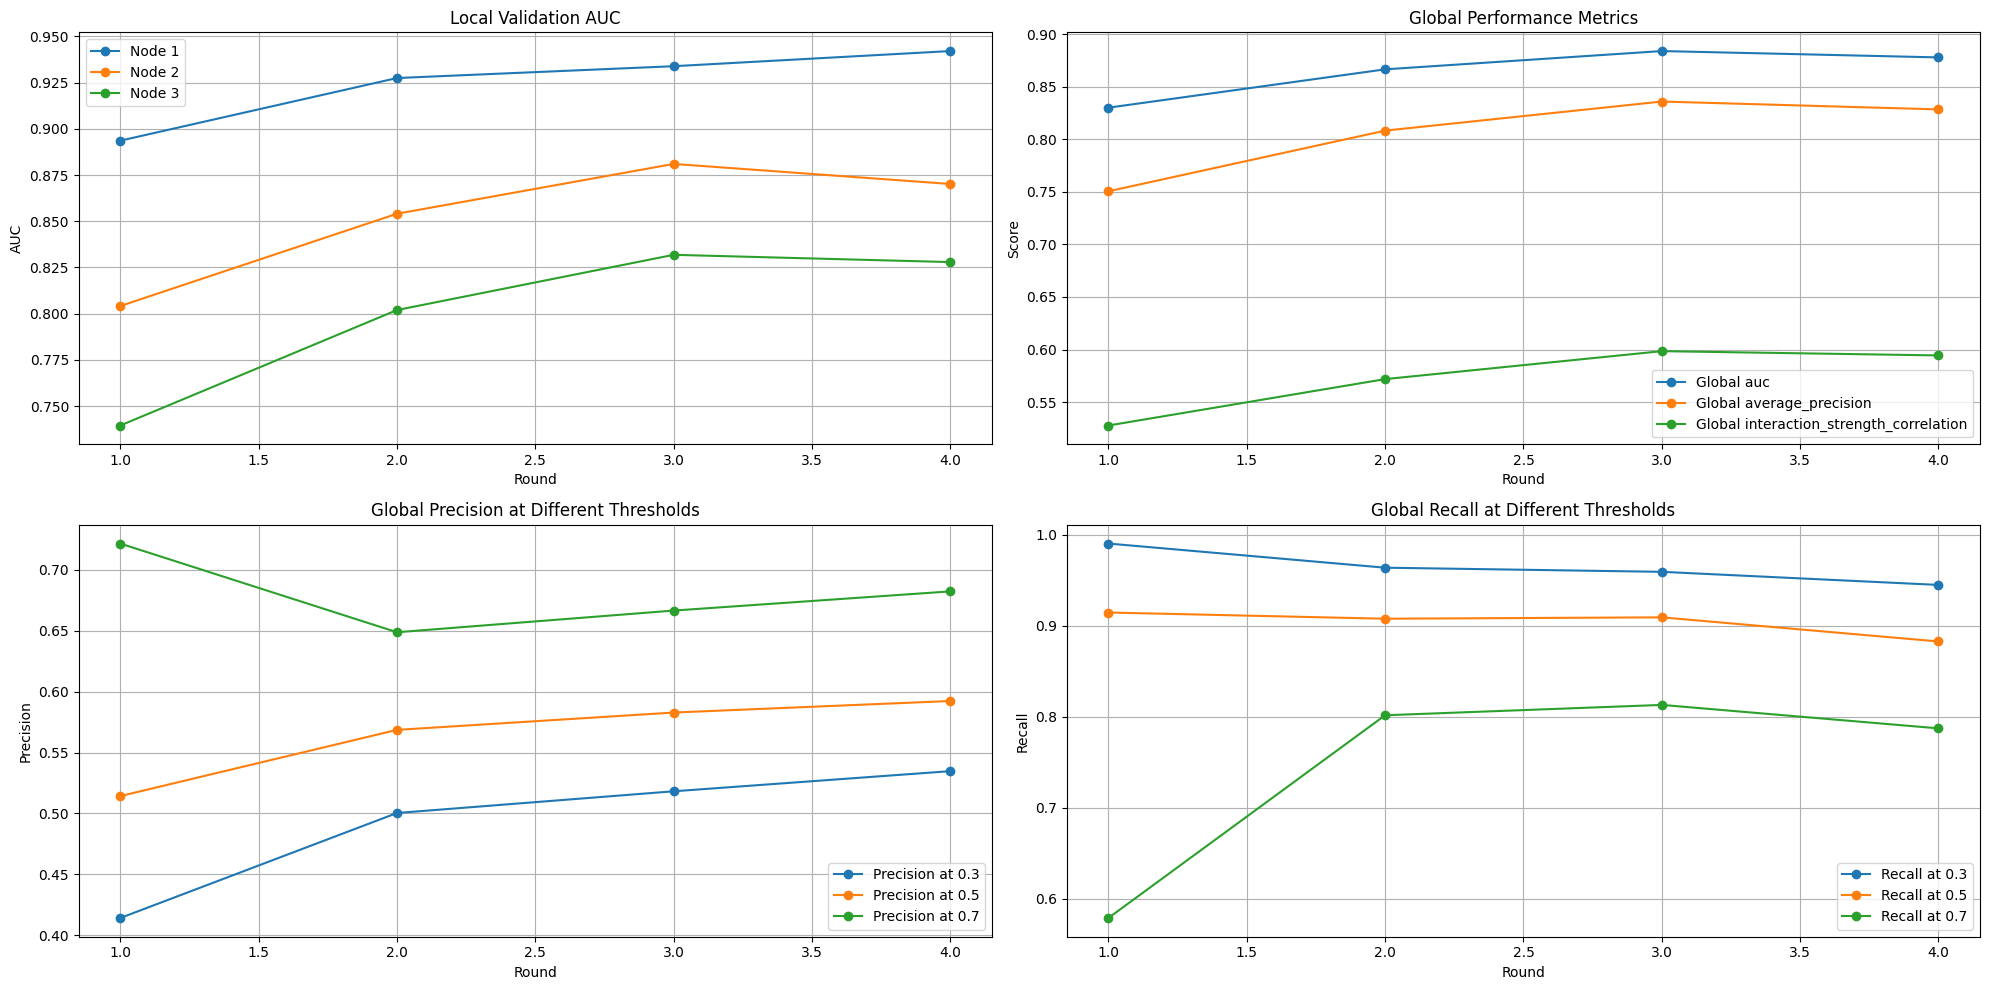


Federated Round 5/5

Training Node 1
Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7816 - auc: 0.9448 - loss: 0.3035 - precision: 0.5748 - recall: 0.9779 - val_accuracy: 0.8171 - val_auc: 0.9499 - val_loss: 0.2978 - val_precision: 0.6239 - val_recall: 0.9489
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8017 - auc: 0.9552 - loss: 0.2770 - precision: 0.6002 - recall: 0.9775 - val_accuracy: 0.8152 - val_auc: 0.9513 - val_loss: 0.2909 - val_precision: 0.6203 - val_recall: 0.9553
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8301 - auc: 0.9628 - loss: 0.2547 - precision: 0.6411 - recall: 0.9764 - val_accuracy: 0.8199 - val_auc: 0.9477 - val_loss: 0.3068 - val_precision: 0.6324 - val_recall: 0.9233
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8349 - auc: 0.9704 - loss: 0.2386 - precision: 0.6404 - recall: 0.9753 - val_accuracy: 0.8143 - val_auc: 0.9490 - val_loss: 0.3037 - val_precision: 0.6216 - val_recall: 0.93

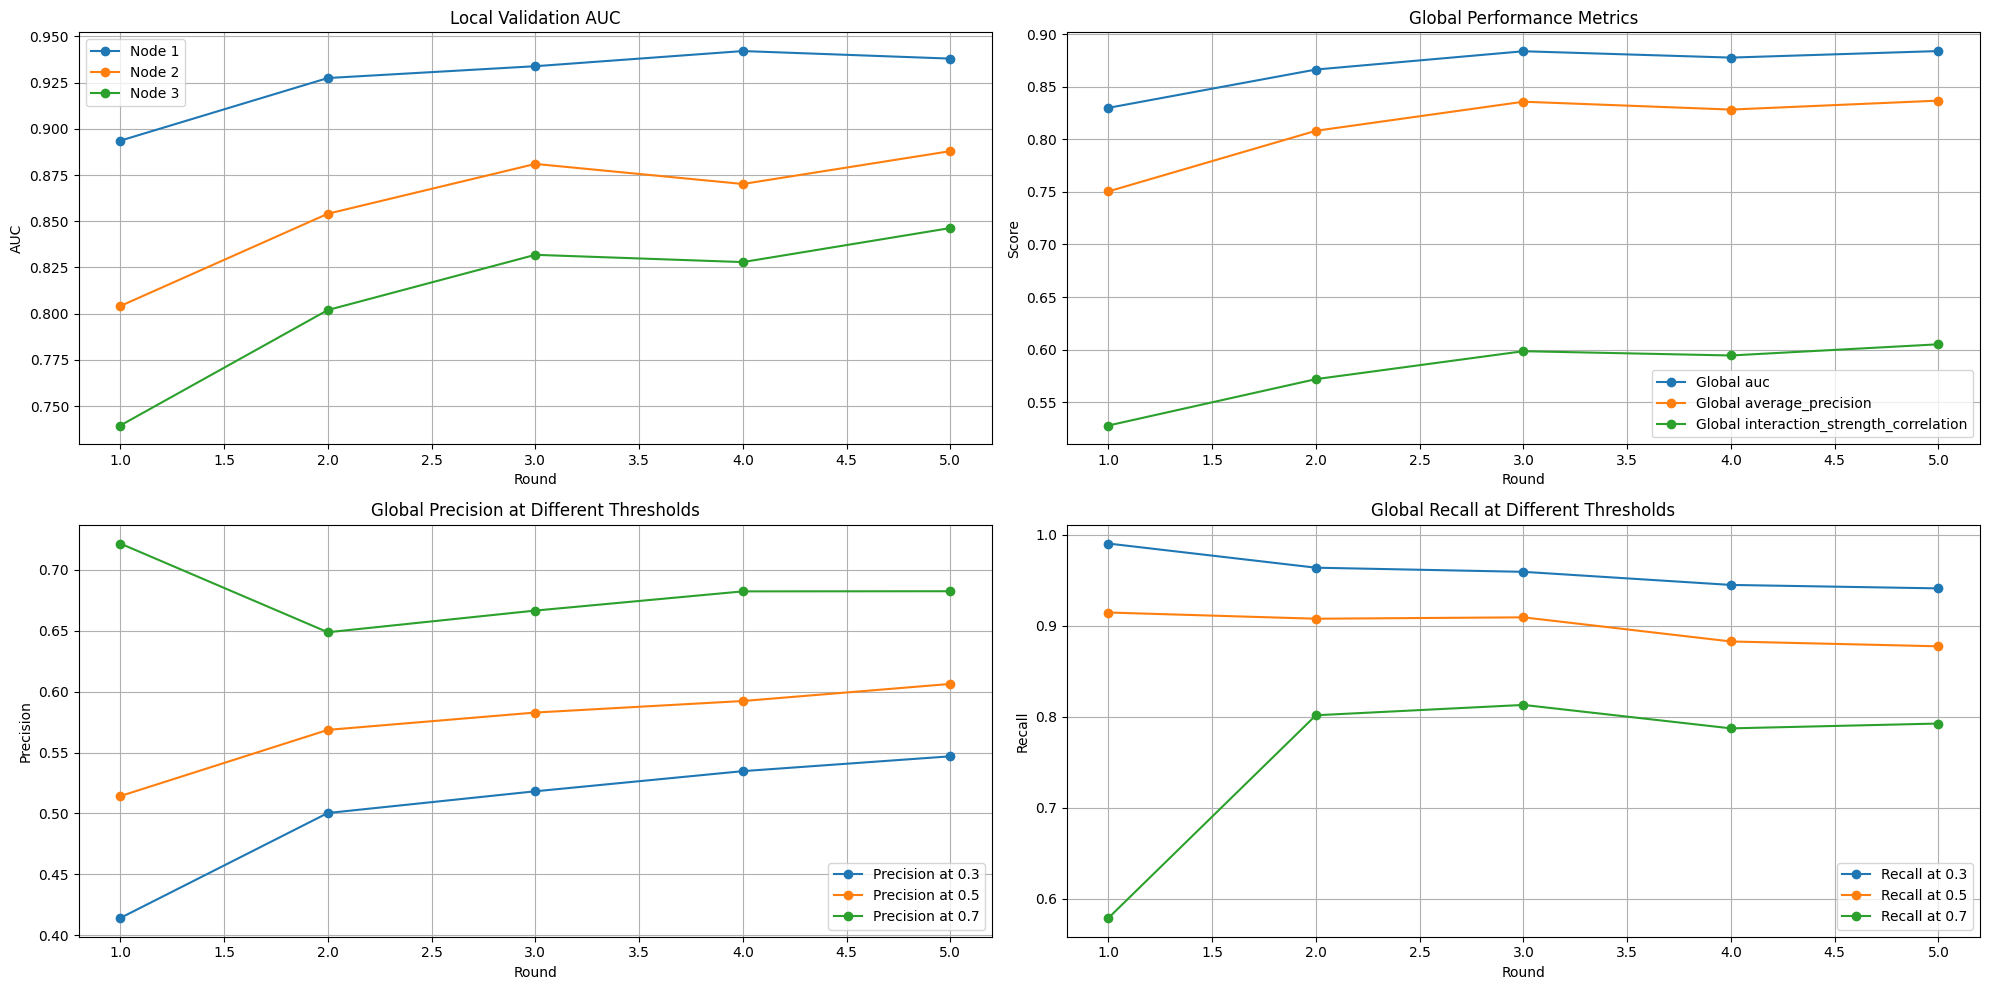


Final Evaluation:

Global Test Set Performance:
AUC: 0.8841
Average Precision: 0.8369
Interaction Strength Correlation: 0.6050

Precision-Recall at Different Thresholds:

At threshold 0.3:
Precision: 0.5469
Recall: 0.9409

At threshold 0.5:
Precision: 0.6063
Recall: 0.8773

At threshold 0.7:
Precision: 0.6823
Recall: 0.7924


In [10]:
# Initial Setup and Imports
%cd /content
!rm -rf *  # Remove everything first
!git clone https://github.com/muhammmad-al/decentralized-ai-content-recommender.git
%cd decentralized-ai-content-recommender

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_score, recall_score
)
import seaborn as sns
import logging
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def preprocess_text(text):
    """Basic text preprocessing"""
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = ' '.join(text.split())
    return text

class GlobalTestSet:
    def __init__(self, test_fraction=0.1):
        self.test_fraction = test_fraction

    def create_global_test_set(self, nodes):
        """Create stratified global test set based on interaction patterns"""
        all_test_indices = []

        for node in nodes:
            # Create interaction strength bins, handling duplicates
            try:
                interaction_quartiles = pd.qcut(
                    node.df['interaction_strength'],
                    q=4,
                    labels=['low', 'medium-low', 'medium-high', 'high'],
                    duplicates='drop'  # Handle duplicate bin edges
                )
            except ValueError:
                # If we can't create quartiles, use binary split
                interaction_quartiles = pd.Series(
                    ['low' if x <= node.df['interaction_strength'].median() else 'high'
                     for x in node.df['interaction_strength']],
                    index=node.df.index
                )

            for group in interaction_quartiles.unique():
                group_mask = interaction_quartiles == group
                group_indices = node.df[group_mask].index.values

                n_test = int(len(group_indices) * self.test_fraction)
                if n_test > 0:  # Only sample if we have indices
                    test_indices = np.random.choice(
                        group_indices,
                        size=n_test,
                        replace=False
                    )
                    all_test_indices.extend(test_indices)

        # Remove test indices from training data
        for node in nodes:
            node.global_test_data = node.df.loc[
                node.df.index.isin(all_test_indices)
            ]
            node.df = node.df.loc[
                ~node.df.index.isin(all_test_indices)
            ]
            node.prepare_data()

        return all_test_indices

    def evaluate_global_performance(self, model, nodes):
        """Evaluate interaction prediction performance on global test set"""
        metrics = {}
        all_predictions = []
        all_true_labels = []
        all_interaction_strengths = []

        for node in nodes:
            X_test = node.prepare_features(node.global_test_data)
            y_test = node.prepare_labels(node.global_test_data)

            predictions = model.predict(X_test)
            all_predictions.extend(predictions)
            all_true_labels.extend(y_test)
            all_interaction_strengths.extend(
                node.global_test_data['interaction_strength'].values
            )

        metrics['auc'] = roc_auc_score(all_true_labels, all_predictions)
        metrics['average_precision'] = average_precision_score(
            all_true_labels,
            all_predictions
        )

        # Correlation between predicted probabilities and actual interaction strength
        metrics['interaction_strength_correlation'] = np.corrcoef(
            np.array(all_predictions).flatten(),
            all_interaction_strengths
        )[0, 1]

        # Calculate metrics at different probability thresholds
        thresholds = [0.3, 0.5, 0.7]
        for threshold in thresholds:
            binary_preds = (np.array(all_predictions) > threshold).astype(int)
            metrics[f'precision_at_{threshold}'] = precision_score(
                all_true_labels,
                binary_preds
            )
            metrics[f'recall_at_{threshold}'] = recall_score(
                all_true_labels,
                binary_preds
            )

        return metrics

class FederatedNode:
    def __init__(self, df, node_number):
        self.df = df
        self.node_number = node_number
        self.global_test_data = None
        self.prepare_data()

    def prepare_data(self):
        """Prepare node data for training interaction prediction"""
        self.vectorizer = TfidfVectorizer(
            max_features=300,
            stop_words='english',
            ngram_range=(1, 1),
            min_df=2,
            max_df=0.95
        )
        X_text = self.vectorizer.fit_transform(self.df['combined_text']).toarray()

        numerical_features = [
            'score_log', 'comments_log', 'text_word_count',
            'sentiment_compound', 'sentiment_magnitude'
        ]
        X_numerical = self.df[numerical_features].fillna(0).values

        self.X = np.hstack([X_text, X_numerical])

        # Create interaction target variable (binary: interacted or not)
        self.y = (self.df['interaction_strength'] > 0).astype(float)

        # Normalize sample weights
        self.sample_weights = self.df['engagement_duration'].clip(lower=0.1)
        self.sample_weights = self.sample_weights / self.sample_weights.mean()

        # Stratified split to maintain class balance
        self.X_train, self.X_val, self.y_train, self.y_val, self.weights_train, self.weights_val = train_test_split(
            self.X, self.y, self.sample_weights,
            test_size=0.2,
            stratify=self.y,
            random_state=42+self.node_number
        )

    def prepare_features(self, data):
        """Prepare features for evaluation"""
        X_text = self.vectorizer.transform(data['combined_text']).toarray()

        numerical_features = [
            'score_log', 'comments_log', 'text_word_count',
            'sentiment_compound', 'sentiment_magnitude'
        ]
        X_numerical = data[numerical_features].fillna(0).values

        return np.hstack([X_text, X_numerical])

    def prepare_labels(self, data):
        """Prepare interaction labels for evaluation"""
        return (data['interaction_strength'] > 0).astype(float)

    def create_model(self):
        """Create the neural network model for interaction prediction"""
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu',
                                input_shape=(self.X_train.shape[1],),
                                kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[
                'accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )
        return model

    def train_local(self, global_weights):
        """Train the model on local data"""
        model = self.create_model()
        model.set_weights(global_weights)

        history = model.fit(
            self.X_train,
            self.y_train,
            sample_weight=self.weights_train,
            epochs=5,
            batch_size=32,
            validation_data=(self.X_val, self.y_val, self.weights_val),
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_auc',
                    patience=3,
                    restore_best_weights=True
                )
            ],
            verbose=1
        )

        return model.get_weights(), history.history

class FederatedServer:
    def __init__(self, input_shape, num_rounds=5):
        self.num_rounds = num_rounds
        self.global_model = self.create_global_model(input_shape)
        self.metrics_history = []
        self.global_evaluator = GlobalTestSet()

    def create_global_model(self, input_shape):
        """Create the global model"""
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu',
                                input_shape=input_shape,
                                kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[
                'accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )
        return model

    def fedavg(self, weights_list, node_sizes):
        """Perform federated averaging of model weights"""
        total_size = sum(node_sizes)
        weighted_weights = []

        for weights, size in zip(weights_list, node_sizes):
            scaling = size / total_size
            weighted = [layer * scaling for layer in weights]
            weighted_weights.append(weighted)

        averaged_weights = []
        for layers in zip(*weighted_weights):
            averaged_weights.append(sum(layers))

        return averaged_weights

    def train(self, nodes):
        """Train the federated model"""
        # Create global test set before training
        self.global_evaluator.create_global_test_set(nodes)

        for round_num in range(self.num_rounds):
            print(f"\nFederated Round {round_num + 1}/{self.num_rounds}")
            print("=" * 50)

            global_weights = self.global_model.get_weights()

            weights_list = []
            node_sizes = []
            node_histories = []

            for node in nodes:
                print(f"\nTraining Node {node.node_number}")
                weights, history = node.train_local(global_weights)
                weights_list.append(weights)
                node_sizes.append(len(node.X_train))
                node_histories.append(history)

            new_weights = self.fedavg(weights_list, node_sizes)
            self.global_model.set_weights(new_weights)

            # Evaluate performance
            local_metrics = self.evaluate_local_performance(nodes)
            global_metrics = self.global_evaluator.evaluate_global_performance(
                self.global_model,
                nodes
            )

            self.metrics_history.append({
                'round': round_num + 1,
                'local_metrics': local_metrics,
                'global_metrics': global_metrics,
                'node_histories': node_histories
            })

            self.plot_metrics(round_num + 1)

    def evaluate_local_performance(self, nodes):
        """Evaluate model performance on local validation sets"""
        metrics = []

        for node in nodes:
            results = self.global_model.evaluate(
                node.X_val,
                node.y_val,
                sample_weight=node.weights_val,
                verbose=0
            )

            # Create metrics dictionary with proper metric names
            metrics_dict = {
                'loss': results[0],
                'accuracy': results[1],
                'auc': results[2],
                'precision': results[3],
                'recall': results[4]
            }
            metrics_dict['node'] = node.node_number
            metrics.append(metrics_dict)

            print(f"Node {node.node_number} Validation Metrics:")
            for metric_name, value in metrics_dict.items():
                if metric_name != 'node':
                    print(f"{metric_name}: {value:.4f}")

        return metrics

    def plot_metrics(self, current_round):
        """Plot training metrics"""
        plt.figure(figsize=(20, 10))

        # Plot 1: Local validation AUC
        plt.subplot(2, 2, 1)
        for node_idx in range(3):
            auc_values = [round_metric['local_metrics'][node_idx]['auc']
                         for round_metric in self.metrics_history]
            plt.plot(range(1, current_round + 1), auc_values,
                    marker='o', label=f'Node {node_idx + 1}')

        plt.title('Local Validation AUC')
        plt.xlabel('Round')
        plt.ylabel('AUC')
        plt.legend()
        plt.grid(True)

        # Plot 2: Global metrics
        plt.subplot(2, 2, 2)
        metrics_to_plot = ['auc', 'average_precision', 'interaction_strength_correlation']
        for metric in metrics_to_plot:
            values = [round_metric['global_metrics'][metric]
                     for round_metric in self.metrics_history]
            plt.plot(range(1, current_round + 1), values,
                    marker='o', label=f'Global {metric}')

        plt.title('Global Performance Metrics')
        plt.xlabel('Round')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

        # Plot 3: Precision at different thresholds
        plt.subplot(2, 2, 3)
        thresholds = [0.3, 0.5, 0.7]
        for threshold in thresholds:
            values = [round_metric['global_metrics'][f'precision_at_{threshold}']
                     for round_metric in self.metrics_history]
            plt.plot(range(1, current_round + 1), values,
                    marker='o', label=f'Precision at {threshold}')

        plt.title('Global Precision at Different Thresholds')
        plt.xlabel('Round')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid(True)

        # Plot 4: Recall at different thresholds
        plt.subplot(2, 2, 4)
        for threshold in thresholds:
            values = [round_metric['global_metrics'][f'recall_at_{threshold}']
                     for round_metric in self.metrics_history]
            plt.plot(range(1, current_round + 1), values,
                    marker='o', label=f'Recall at {threshold}')

        plt.title('Global Recall at Different Thresholds')
        plt.xlabel('Round')
        plt.ylabel('Recall')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

def load_node_data(node_number):
    """Load node data with additional user interaction features"""
    # Load content datasets
    datasets = {
        'ai': pd.read_csv('data/raw/reddit_analysis_ai_5000_posts_with_sentiment.csv'),
        'music': pd.read_csv('data/raw/reddit_analysis_music_5000_posts_with_sentiment.csv'),
        'web3': pd.read_csv('data/raw/reddit_analysis_web3_5000_posts_with_sentiment.csv')
    }

    # Load synthetic user interactions
    user_interactions = pd.read_csv('data/mock/user_interactions.csv')

    # Process timestamps
    for df in datasets.values():
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['hour_utc'] = df['timestamp'].dt.hour

    def assign_region(hour):
        if 2 <= hour < 10:
            return 'EU'
        elif 10 <= hour < 18:
            return 'NA'
        else:
            return 'ASIA'

    region_map = {1: 'NA', 2: 'EU', 3: 'ASIA'}
    target_region = region_map[node_number]

    balanced_dfs = []
    for category, df in datasets.items():
        # Filter by region
        df['region'] = df['hour_utc'].apply(assign_region)
        regional_df = df[df['region'] == target_region].copy()

        # Add interaction features
        category_interactions = user_interactions[user_interactions['category'] == category]
        interaction_features = category_interactions.groupby('content_id').agg({
            'interaction_strength': 'mean',
            'engagement_duration': 'mean',
            'interaction_type': lambda x: x.value_counts().index[0]
        }).reset_index()

        regional_df = pd.merge(
            regional_df,
            interaction_features,
            left_index=True,
            right_on='content_id',
            how='left'
        )

        # Fill missing values
        regional_df['interaction_strength'] = regional_df['interaction_strength'].fillna(0)
        regional_df['engagement_duration'] = regional_df['engagement_duration'].fillna(0)
        regional_df['interaction_type'] = regional_df['interaction_type'].fillna('none')

        balanced_dfs.append(regional_df)

    df = pd.concat(balanced_dfs, ignore_index=True)

    # Feature engineering
    df['cleaned_title'] = df['title'].apply(preprocess_text)
    df['cleaned_content'] = df['cleaned_text'].apply(preprocess_text)
    df['combined_text'] = df['cleaned_title'] + ' ' + df['cleaned_content']
    df['score_log'] = np.log1p(df['score'])
    df['comments_log'] = np.log1p(df['num_comments'])
    df['text_word_count'] = df['combined_text'].str.split().str.len()
    df['sentiment_compound'] = (df['textblob_sentiment'] + df['transformer_score']) / 2
    df['sentiment_magnitude'] = abs(df['textblob_sentiment'])

    # Scale numerical features
    numerical_cols = ['score_log', 'comments_log', 'text_word_count',
                     'sentiment_compound', 'sentiment_magnitude',
                     'interaction_strength', 'engagement_duration']

    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Print dataset statistics
    print(f"\nNode {node_number} ({target_region}) Dataset Overview:")
    print(f"Total samples: {len(df)}")
    print("\nInteraction Statistics:")
    print(f"Posts with interactions: {(df['interaction_strength'] > 0).sum()}")
    print(f"Interaction rate: {((df['interaction_strength'] > 0).mean() * 100):.2f}%")
    print(f"Average engagement duration: {df['engagement_duration'].mean():.2f}")

    return df

def make_predictions(server, nodes, new_content_df):
    """Make predictions on new content"""
    # Prepare features using the first node's preprocessing pipeline
    reference_node = nodes[0]
    X_new = reference_node.prepare_features(new_content_df)

    # Get interaction probabilities
    probabilities = server.global_model.predict(X_new)

    # Add predictions to the dataframe
    results_df = new_content_df.copy()
    results_df['interaction_probability'] = probabilities

    # Add prediction confidence levels
    results_df['confidence_level'] = pd.cut(
        results_df['interaction_probability'],
        bins=[0, 0.3, 0.7, 1],
        labels=['low', 'medium', 'high']
    )

    return results_df

def main():
    """Main execution function"""
    print("Starting Federated Learning Training...")

    # Create nodes
    nodes = []
    for node_num in [1, 2, 3]:
        df = load_node_data(node_num)
        nodes.append(FederatedNode(df, node_num))

    # Initialize server
    input_shape = (nodes[0].X_train.shape[1],)
    server = FederatedServer(input_shape, num_rounds=5)

    # Train federated model
    server.train(nodes)

    # Print final evaluation
    print("\nFinal Evaluation:")
    print("=" * 50)
    final_metrics = server.metrics_history[-1]

    print("\nGlobal Test Set Performance:")
    print(f"AUC: {final_metrics['global_metrics']['auc']:.4f}")
    print(f"Average Precision: {final_metrics['global_metrics']['average_precision']:.4f}")
    print(f"Interaction Strength Correlation: {final_metrics['global_metrics']['interaction_strength_correlation']:.4f}")

    print("\nPrecision-Recall at Different Thresholds:")
    thresholds = [0.3, 0.5, 0.7]
    for threshold in thresholds:
        print(f"\nAt threshold {threshold}:")
        print(f"Precision: {final_metrics['global_metrics'][f'precision_at_{threshold}']:.4f}")
        print(f"Recall: {final_metrics['global_metrics'][f'recall_at_{threshold}']:.4f}")

    return server, nodes

if __name__ == "__main__":
    server, nodes = main()